### 👨‍🏭 Albertus Septian Angkuw

### Pembuatan Call Graph

In [ ]:
%pip install pycg

In [ ]:
folderSC = "odoo-16"
# currentPath = input("")
currentPath = "/home/asa/Documents/Skripsi/TA-1119002/rancangan-dekomposisi"
print('Current Path set:' ,currentPath)

In [ ]:
import os
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [ ]:
import time
def scanPyCG(currentPath,package):
    timestamp = int(time.time())
    targetFile = f'py_files=$(find {currentPath}/{package} -type f -name "*.py")'
    execute = f'pycg --package {package} $py_files -o {currentPath}/{package}-{timestamp}.json '
    os.system(f'{targetFile} && {execute}')
    return f'{currentPath}/{package}-{timestamp}.json'

In [ ]:
scannedFiles = walkTroughFolder(folderSC)
print(f'Total Files Scanned py Source Code: {len(scannedFiles)}')

In [ ]:
# addonsJSON = scanPyCG(currentPath,f'{folderSC}/addons')
# odooJSON = scanPyCG(currentPath,f'{folderSC}/odoo')

In [ ]:
addonsJSON = f'{currentPath}/odooOnlyAddonsNoPackage.json'
odooJSON = f'{currentPath}/odooCoreNoPackage.json'

### Pembacaan Hasil Call Graph JSON

In [ ]:
import json
def loadJSON(path):
   return json.load(open(path))

In [ ]:
cgAddonsSource =loadJSON(addonsJSON)
cgOdooSource =loadJSON(odooJSON)
print(list(cgAddonsSource.values())[:5])
print(list(cgOdooSource.values())[:5])

In [ ]:
print(len(cgOdooSource))
print(len(cgAddonsSource))

In [ ]:
def getListRootPackage(path):
    listRootPackage = []
    for file in os.listdir(f'{path}'):
        if os.path.isdir(f'{path}/{file}'):
            listRootPackage.append(file)
        elif file.endswith('.py'):
            listRootPackage.append('.'.join(file.split(".")[:-1]))
    return listRootPackage

In [ ]:
def addPrefixFolder(cg,root,listPackage):
    def checkParent(key):
        parentkey = key.split('.')[0]
        if parentkey in listPackage:
            key = f'{root}.{key}'
        return key
    newCG = {}
    for key, relation in cg.items():
        key = checkParent(key)
        if key not in newCG:
            newCG[key] = []
        for i in relation:
            newRelKey = checkParent(i)
            newCG[key].append(newRelKey)
    return newCG

In [ ]:
listPackageOdoo = getListRootPackage(f'{currentPath}/{folderSC}/odoo')
listPackageAddons = getListRootPackage(f'{currentPath}/{folderSC}/addons')

In [ ]:
cgOdoo = addPrefixFolder(cgOdooSource,"odoo",listPackageOdoo)
cgAddons = addPrefixFolder(cgAddonsSource,"addons",listPackageAddons)

In [ ]:
cgSource = {}
for key, rel in cgOdoo.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

for key, rel in cgAddons.items():
    if key not in cgSource:
        cgSource[key] = []
    for tmp in rel:
        if tmp not in cgSource:
            cgSource[tmp] = []
    cgSource[key] = cgSource[key] + rel

In [ ]:
len(cgSource)

### Visualisasi Call Graph

In [ ]:
%pip install pygraphviz

In [ ]:
import pygraphviz as pgv
def cobaDot():
    d = {"1": {"2": 7 }, "2": {"1": 1, "3": 1, "5" : 1}}
    A = pgv.AGraph(d,strict=False, directed=True)
    A.layout(prog="dot")
    A.draw(f'{currentPath}/contoh-CG.svg') 
    print(A)
#cobaDot()

In [ ]:
def buatGraphviz(graph, _strict=False, _directed=True,_prog="fdp",filename=folderSC):
    A = pgv.AGraph(graph,strict=_strict, directed=_directed)
    A.layout(prog=_prog)
    A.draw(f'{currentPath}/{filename}.svg') 
    print(f'Image saved at: {currentPath}/{filename}.svg')

#### Call Graph Raw

In [ ]:
callGraphRaw = {}
for key, value in cgSource.items():
    callGraphRaw[key] = {}
    for v in value:
        callGraphRaw[key][v] = 1

In [ ]:
# buatGraphviz(graph=callGraphRaw,filename=f'{folderSC}-RAW-CG')

#### Filter Call diluar Project

In [ ]:
callGraphFiltered = {}
listRootFolder = [ 'odoo', 'addons']
edgeGraph = []
outsideCall = set()
for key, value in cgSource.items():
    rootSource = key.split('.')[0]
    if rootSource not in listRootFolder:
        outsideCall.add(rootSource)
        continue
    childFilter = {}
    for v in value:
        childSource = v.split('.')[0]
        if childSource not in listRootFolder:
            outsideCall.add(childSource)
            continue
        childFilter[v] = 1
    if len(childFilter) == 0:
        edgeGraph.append(key)
        continue
    for c in childFilter:
        if c not in callGraphFiltered:
            callGraphFiltered[c] = {}
    callGraphFiltered[key] = childFilter
    
print(f'Total Top Node: {len(callGraphFiltered)} ')
print(f'Total Edge: {len(edgeGraph)} <{edgeGraph[:3]}>')
print(f'Total OutsideEdge: {len(outsideCall)} <{list(outsideCall)[:3]}>')

In [ ]:
buatGraphviz(callGraphFiltered,filename=f'{folderSC}-CG')

In [ ]:
cgSource['addons.mrp.models.mrp_routing.MrpRoutingWorkcenter.copy_existing_operations']

In [ ]:
callGraphFiltered['addons.mrp.models.mrp_routing.MrpRoutingWorkcenter.copy_existing_operations']

#### Extrasi Data

In [ ]:
import os
import importlib.util
import inspect

In [ ]:
def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)

In [ ]:
# Checks if file is a broken link. 0: broken link; 1: valid link; 2: not a link
def isvalidlink(path):
    if not os.path.islink(path):
        return 2
    try:
        os.stat(path)
    except os.error:
        return 0
    return 1

In [ ]:
def merge_symlink(target, source):
    for file in os.listdir(source):
        if os.path.isdir(f'{source}/{file}') :
            if os.path.isdir(f'{target}/{file}'):
                print("Existing Folder in target folder " , file)
                continue
            if isvalidlink(f'{target}/{file}') == 1:
                os.unlink( f'{target}/{file}')
                print("Removed Old Link in target folder " , file)
            symlink_rel(f'{source}/{file}', f'{target}/{file}')
            if isvalidlink(f'{target}/{file}') == 0:
                print("Please Remove broken symlink: {}".format(file))
                return 
            print(f'Added Symslink: {source}/{file} -> {target}/{file}')

In [ ]:
def unmerge_symlink(target):
    # Delete All Links
    for file in os.listdir(target):
        link = os.path.join(target,file)
        if isvalidlink(link) == 1:
            os.unlink( f'{target}/{file}')
            print("Clean Up  symlink: {}".format(file))

In [ ]:
merge_symlink('odoo/addons','addons')
runcommand = importlib.import_module("addons.account.models")
for name, obj in inspect.getmembers(runcommand):
    if inspect.ismodule(obj):
        print("Module:" ,  name)
        member = inspect.getmembers(obj)
        tmpClass = {}
        for item in member:
            if inspect.isclass(item[1]):
                if hasattr(item[1], '__class__') and str(item[1].__class__) != "<class 'odoo.models.MetaModel'>":
                    print(f'Class "{item[0]}" Skipped because not MetaModel')
                    continue
                if hasattr(item[1], '_name'):
                    tmpClass[item[0]] = { name: item[1]._name}
                if hasattr(item[1], '_inherit'):
                    tmpClass[item[0]]['inherit'] = item[1]._inherit                       
                if hasattr(item[1], '_inherits'):
                    tmpClass[item[0]]['inherits'] = item[1]._inherits
                classMembers = inspect.getmembers(item[1])
                tmpClass[item[0]]['attribute_rel'] = {}
                for attrClass in classMembers:
                    if hasattr(attrClass[1], 'comodel_name'):
                        if attrClass[1].comodel_name != None:
                            tmpClass[item[0]]['attribute_rel'][attrClass[0]] = attrClass[1].comodel_name 
        print(f'Total Model Class: {len(tmpClass)} ')
        print("--------------------")
unmerge_symlink('odoo/addons')

#### Pemberian Weight pada Graph

In [ ]:
weightedGraph = {}
weightedGraph[folderSC] = {}
for file in scannedFiles:
    newKey = '.'.join(file[:-3].split("/")[2:])
    weightedGraph[newKey] = {}


In [ ]:
weightedGraph = callGraphFiltered

#### Disjoint-set data structure

In [ ]:
currIter = 0
for call, listConn in callGraphFiltered.items():
    if call in weightedGraph:
        print(call , listConn)
        #???
    parentCall = call
    while (parentCall not in weightedGraph):
        parentCall = parentCall.rsplit('.', 1)[0]
    
    for conn, weight in listConn.items():
        parentConn = conn.rsplit('.', 1)[0]
        while (parentConn not in weightedGraph):
            parentConn = parentConn.rsplit('.', 1)[0]
             
        if parentConn not in weightedGraph[parentCall]:
            weightedGraph[parentCall][parentConn] = 1
        else:
            weightedGraph[parentCall][parentConn] += 1
    currIter+=1   


In [ ]:
# buatGraphviz(weightedGraph ,filename=f'{folderSC}-W-CG')

#### Representasi Call Graph menjadi Adjacency Matrix

In [ ]:
%pip install numpy

In [26]:
import numpy as np
def createAdjacentMatrix(graphSource):
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    tmpNotDetected = 0
    for x, connection in graphSource.items():
        for name, weight in connection.items():
            if name not in listLabel:
                # print(x)
                tmpNotDetected += 1
                continue
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    print("Not Detected: " , tmpNotDetected)
    return adjMatrix, listLabel

In [ ]:
adjMatrix, listLabel = createAdjacentMatrix(weightedGraph)


In [ ]:
len(listLabel)

In [ ]:
# np.savetxt(f'{folderSC}-AdjMatrix.csv', adjMatrix, delimiter=",")

#### Distance Matrix

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster,linkage
from scipy.spatial import distance

In [137]:
graphExample =[ 
[1,	1,	1,	0,	0,	0,	0],
[0,	1,	0,	1,	0,	0,	0],
[0,	0,	1,	0,	0,	0,	0],
[0,	0,	0,	1,	0,	0,	0],
[0,	0,	0,	0,	1,	0,	0],
[0,	0,	0,	0,	1,	1,	1],
[0,	0,	0,	0,	0,	0,	1]]

In [133]:
graphExample =[ 
[0,	1,	1,	0,	0,	0,	0],
[0,	0,	0,	1,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	1,	0,	1],
[0,	0,	0,	0,	0,	0,	0]]

In [138]:
def calculateDistance(A,B):
    return distance.jaccard(A,B)

In [139]:
data = np.array(graphExample)

In [140]:
distanceMatrix = [ 
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0],
[0,	0,	0,	0,	0,	0,	0]]
for x in range(0,len(data)):
    for y in range(0,x):
        distanceMatrix[x][y] = calculateDistance(data[x, :], data[y, :])
        distanceMatrix[y][x] = distanceMatrix[x][y]
print(distanceMatrix)

[[0, 0.75, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0], [0.75, 0, 1.0, 0.5, 1.0, 1.0, 1.0], [0.6666666666666666, 1.0, 0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.5, 1.0, 0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0, 0.6666666666666666, 1.0], [1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0, 0.6666666666666666], [1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 0]]


/tmp/ipykernel_9144/3205337508.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tmpz = linkage(distanceMatrix)


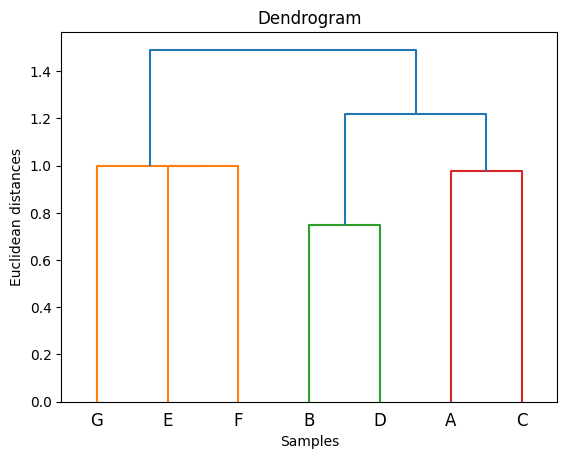

In [141]:
# import sys
# sys.setrecursionlimit(100000)
tmpz = linkage(distanceMatrix)
dend = sch.dendrogram(tmpz,labels=['A','B','C','D', 'E', 'F', 'G'])
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
plt.figure(figsize=(20,6))
z = linkage(dist_matrix)
# dend = sch.dendrogram(z,labels=list(listLabel))
dend = sch.dendrogram(z)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()

#### Clustering

In [ ]:
%pip install scipy
%pip install matplotlib

In [23]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, median, centroid, weighted, average, complete, single, fcluster,linkage
from scipy.spatial.distance import pdist

In [ ]:
#Normalisasi Data
#sklearn.preprocessing.normalize()

In [ ]:
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

fig, ax = plt.subplots()
im = ax.imshow(adjMatrix)

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(list(listLabel))), labels=list(listLabel))
# ax.set_yticks(np.arange(len(list(listLabel))), labels=list(listLabel))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Heatmap Relation Between Files .py")

# plt.figure(figsize=(20,6))
plt.show()

##### Todo: Pemilihan Cluster Terbaik berdasarkan ....